# Exploratory Data Analysis

## Overview
Previously, we worked with two datasets:
1. **TMQ20 Dataset**: Likely contains tourism-related metrics (e.g., Area of Residence, Reason for Journey, Average Length of Stay, Expenditure, Percentage of Trips, Year).
2. **Trips per Quarter Dataset**: Contains trip-related data aggregated on a quarterly basis.

The goal was to merge these datasets, prepare the data, and apply descriptive statistics to gain insights.

## Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as plgo
from scipy.stats.mstats import winsorize

### Custom Functions

In [6]:
def show_unique_values(data):
    columns = data.select_dtypes(include=['object']).columns
    for column in columns:
         print(f"Unique values in column '{column}':\n {data[column].unique()}\n")

def calculate_variance(data):
    columns= data.select_dtypes(exclude=['object']).columns
    for column in columns:
        print(f'Variance of {column}: {data[column].var()}')

def show_histplot(data, columns=None, kde=True, bins=50, title=None):
    if columns is None:
        columns = data.select_dtypes(exclude=['object']).columns
    for column in columns:
        sns.histplot(data= data, x= column, kde= kde, bins=bins)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

def show_scatterplot(data=None, x=None, y=None, hue=None, hover=None, x_threshold=None, y_threshold=None):

    figure = px.scatter(data, x=x, y=y, color=hue, hover_data=hover)
    figure.update_layout(title=f'{x} vs. {y} by {hue}')

    if x_threshold is not None:
        threshold = count_outliers_percentile(data, x, x_threshold)
        figure.add_trace(plgo.Scatter(
            x=[threshold, threshold],
            y=[data[y].min(), data[y].max()],
            mode="lines",
            line=dict(color="red", dash="dash"),
            name=f"X Threshold ({threshold})"
        ))

    if y_threshold is not None:
        threshold = count_outliers_percentile(data, y, y_threshold)
        figure.add_trace(plgo.Scatter(
            x=[data[x].min(), data[x].max()],
            y=[threshold, threshold],
            mode="lines",
            line=dict(color="red", dash="dash"),
            name=f"Y Threshold ({threshold})"
        ))
    figure.show()

def show_barplot(data, x, y, hue=None, errorbar=True,x_threshold=None, y_threshold=None):
    sns.barplot(data=data, x=x, y=y, hue=hue, errorbar=errorbar)
    
    if x_threshold is not None:
        threshold = count_outliers_percentile(data, x, x_threshold)
        plt.axvline(x=threshold, color='red', linestyle='--', label=f"X Threshold ({threshold:.2f})")
        plt.legend()

    if y_threshold is not None:
        threshold = count_outliers_percentile(data, y, y_threshold)
        plt.axhline(y=threshold, color='red', linestyle='--', label=f"Y Threshold ({threshold:.2f})")
        plt.legend()
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.show()

def show_boxplot(data):
    columns = data.select_dtypes(exclude=['object']).columns
    for column in columns:
        sns.boxplot(data= data, x=column, )
        plt.title(f"Boxplot of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

def count_outliers_iqr(data, threshold=1.5):
    columns = data.select_dtypes(exclude=['object']).columns
    outlier_counts = {}
    for column in columns:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr

            outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
            outlier_counts[column] = len(outliers)
            
    return outlier_counts

def remove_outliers_iqr(data, column=None,threshold=1.5):

    filtered_data = data.copy()

    q1 = filtered_data[column].quantile(0.25)
    q3 = filtered_data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    filtered_data = filtered_data[(filtered_data[column] >= lower_bound) & (filtered_data[column] <= upper_bound)]

    return filtered_data

def remove_outliers_percentile(data, column, threshold=0.90):

    threshold = data[column].quantile(threshold)
    index = data[data[column] > threshold].index
    new_data = data.drop(index)
    print(f"Threshold Value: {threshold}")
    print(f"Number of Outliers Removed: {len(index)}")

    return new_data

def count_outliers_percentile(data, column, threshold = 0.90):
    threshold = data[column].quantile(threshold)
    index = data[data[column] > threshold].index
    print(f"Threshold Value: {threshold}")
    print(f"Number of Outliers: {len(index)}")
    return threshold

def transform_data(data, columns, how):
    if how == 'log':
        for column in columns:
            data[column + '_Transform'] = np.log1p(data[column])
        return data
    elif how == 'square root':
        for column in columns:
            data[column + '_Transform'] = np.sqrt(data[column])
        return data
    else:
        print('This method supports either "log" or "square root" methods only!' )

## Ingesting Dataset

In [8]:
main_data = pd.read_csv(r"D:\CCT Learnings\Git\CCT_CA1\Dataset\Inbound Tourism.csv")

### Display the first 5 rows of the Datasets

In [10]:
main_data.head()

Year  Quarter Area of Residence       Reason for Journey  \
0  2012        1     All Countries  All reasons for journey   
1  2012        2     All Countries  All reasons for journey   
2  2012        3     All Countries  All reasons for journey   
3  2012        4     All Countries  All reasons for journey   
4  2013        1     All Countries  All reasons for journey   

   Avg Length of Stay  Expenditure  Overseas Trip Percentage  Total Trips  \
0                 6.8        483.0                     100.0      1165100   
1                 7.0        816.0                     100.0      1817300   
2                 8.1        994.0                     100.0      2096700   
3                 7.2        622.0                     100.0      1438000   
4                 6.7        541.0                     100.0      1251700   

   Number of Trips  Season  
0        1165100.0  Winter  
1        1817300.0  Spring  
2        2096700.0  Summer  
3        1438000.0  Autumn  
4        1251700.0  Winter

#### Distinct values in each columns

To extract and analyze the distinct values from each column in the dataset, providing an overview of the unique entries. Show the number of unique values and examples of distinct entries for each column.

In [13]:
show_unique_values(main_data)

Unique values in column 'Area of Residence':
 ['All Countries' 'France' 'Germany' 'Great Britain' 'Italy'
 'Other Europe (14)' 'Other countries (24)' 'United States and Canada']

Unique values in column 'Reason for Journey':
 ['All reasons for journey' 'Business' 'Holiday/leisure/recreation'
 'Other reason for journey' 'Visit to friends/relatives']

Unique values in column 'Season':
 ['Winter' 'Spring' 'Summer' 'Autumn']



#### Separating aggregated values and dropping unwanted columns

Creating a new DataFrame by separating rows where the `Area of residence` column contains the value **All Countries** and **All reasons for journey** from `Reason for Journey`, as these rows represent aggregate values and dropping `Overseas Trip Percentage` and `Total Trips` as they are not required for analysis and multiplying `Expenditure` with a million to get the actual value.

In [16]:
agg_data = main_data[(main_data['Reason for Journey'] == 'All reasons for journey') & (main_data['Area of Residence'] == 'All Countries')].reset_index(drop=True)

In [17]:
agg_data.head()

Year  Quarter Area of Residence       Reason for Journey  \
0  2012        1     All Countries  All reasons for journey   
1  2012        2     All Countries  All reasons for journey   
2  2012        3     All Countries  All reasons for journey   
3  2012        4     All Countries  All reasons for journey   
4  2013        1     All Countries  All reasons for journey   

   Avg Length of Stay  Expenditure  Overseas Trip Percentage  Total Trips  \
0                 6.8        483.0                     100.0      1165100   
1                 7.0        816.0                     100.0      1817300   
2                 8.1        994.0                     100.0      2096700   
3                 7.2        622.0                     100.0      1438000   
4                 6.7        541.0                     100.0      1251700   

   Number of Trips  Season  
0        1165100.0  Winter  
1        1817300.0  Spring  
2        2096700.0  Summer  
3        1438000.0  Autumn  
4        1251700.0  Winter

In [18]:
data_drop = main_data[(main_data['Reason for Journey'] != 'All reasons for journey') & (main_data['Area of Residence'] != 'All Countries')].reset_index(drop=True)

In [19]:
data_drop = data_drop.drop(columns=['Overseas Trip Percentage', 'Total Trips'], axis=1)
agg_data = agg_data.drop(columns=['Overseas Trip Percentage', 'Total Trips'], axis=1)


In [20]:
data_drop['Expenditure'] = data_drop['Expenditure'] * 1000000
agg_data['Expenditure'] = agg_data['Expenditure'] * 1000000

In [21]:
data_drop.head()

Year  Quarter Area of Residence Reason for Journey  Avg Length of Stay  \
0  2012        1            France           Business                 6.6   
1  2012        2            France           Business                 5.8   
2  2012        3            France           Business                 9.3   
3  2012        4            France           Business                 9.1   
4  2013        1            France           Business                 6.0   

   Expenditure  Number of Trips  Season  
0    9000000.0         104859.0  Winter  
1    6000000.0         109038.0  Spring  
2    6000000.0         146769.0  Summer  
3    5000000.0          71900.0  Autumn  
4    7000000.0         100136.0  Winter

In [22]:
agg_data.head()

Year  Quarter Area of Residence       Reason for Journey  \
0  2012        1     All Countries  All reasons for journey   
1  2012        2     All Countries  All reasons for journey   
2  2012        3     All Countries  All reasons for journey   
3  2012        4     All Countries  All reasons for journey   
4  2013        1     All Countries  All reasons for journey   

   Avg Length of Stay  Expenditure  Number of Trips  Season  
0                 6.8  483000000.0        1165100.0  Winter  
1                 7.0  816000000.0        1817300.0  Spring  
2                 8.1  994000000.0        2096700.0  Summer  
3                 7.2  622000000.0        1438000.0  Autumn  
4                 6.7  541000000.0        1251700.0  Winter

#### Check Duplicated Values

Duplicates can lead to biased analysis and inaccurate results, so identifying and handling them is crucial. Duplicates can skew summary statistics and analysis results. Redundant rows can negatively impact the performance of machine learning models.

In [25]:
data_drop.duplicated().sum()

0

Confirmed that no duplicated rows exist in the dataset.

#### Check Null Values

Null values can lead to incomplete or biased analysis, so identifying and handling them is essential. They can result in missing information, affecting the accuracy of analysis. Many machine learning algorithms cannot handle null values, so they must be addressed before modeling. They also skew summary statistics and visualizations.


In [29]:
data_drop.isnull().sum()

Year                  0
Quarter               0
Area of Residence     0
Reason for Journey    0
Avg Length of Stay    0
Expenditure           0
Number of Trips       0
Season                0
dtype: int64

The dataset contains no null values, ensuring that all entries are complete.

### Summary Statistics on the datasets

In [32]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                896 non-null    int64  
 1   Quarter             896 non-null    int64  
 2   Area of Residence   896 non-null    object 
 3   Reason for Journey  896 non-null    object 
 4   Avg Length of Stay  896 non-null    float64
 5   Expenditure         896 non-null    float64
 6   Number of Trips     896 non-null    float64
 7   Season              896 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 56.1+ KB


In [33]:
data_drop.describe()

Year     Quarter  Avg Length of Stay   Expenditure  \
count   896.000000  896.000000          896.000000  8.960000e+02   
mean   2015.500000    2.500000            9.876563  3.755804e+07   
std       2.292568    1.118658            7.132636  5.528475e+07   
min    2012.000000    1.000000            0.500000  1.000000e+06   
25%    2013.750000    1.750000            5.700000  8.000000e+06   
50%    2015.500000    2.500000            7.800000  2.100000e+07   
75%    2017.250000    3.250000           11.000000  4.500000e+07   
max    2019.000000    4.000000           49.400000  5.540000e+08   

       Number of Trips  
count     8.960000e+02  
mean      3.156271e+05  
std       3.145465e+05  
min       1.165100e+04  
25%       1.071638e+05  
50%       1.952320e+05  
75%       4.024280e+05  
max       1.867515e+06

In [34]:
calculate_variance(data_drop)

Variance of Year: 5.255865921787709
Variance of Quarter: 1.2513966480446927
Variance of Avg Length of Stay: 50.874489175977665
Variance of Expenditure: 3056403332003190.0
Variance of Number of Trips: 98939516175.09909


#### Pairplot and Heatmap correlation for analysis

As part of my analysis , 
- I use **Pairplot** to quickly and effectively explore relationships and patterns in my dataset. It allows me to visualize multiple pairwise relationships in a single plot, saving time during EDA.
- I use **Heatmap Correlation** to visually represent the relationships and dependencies between numerical variables in a dataset. It provides a clear, color-coded matrix of correlation coefficients, making it easy to interpret relationships at a glance.

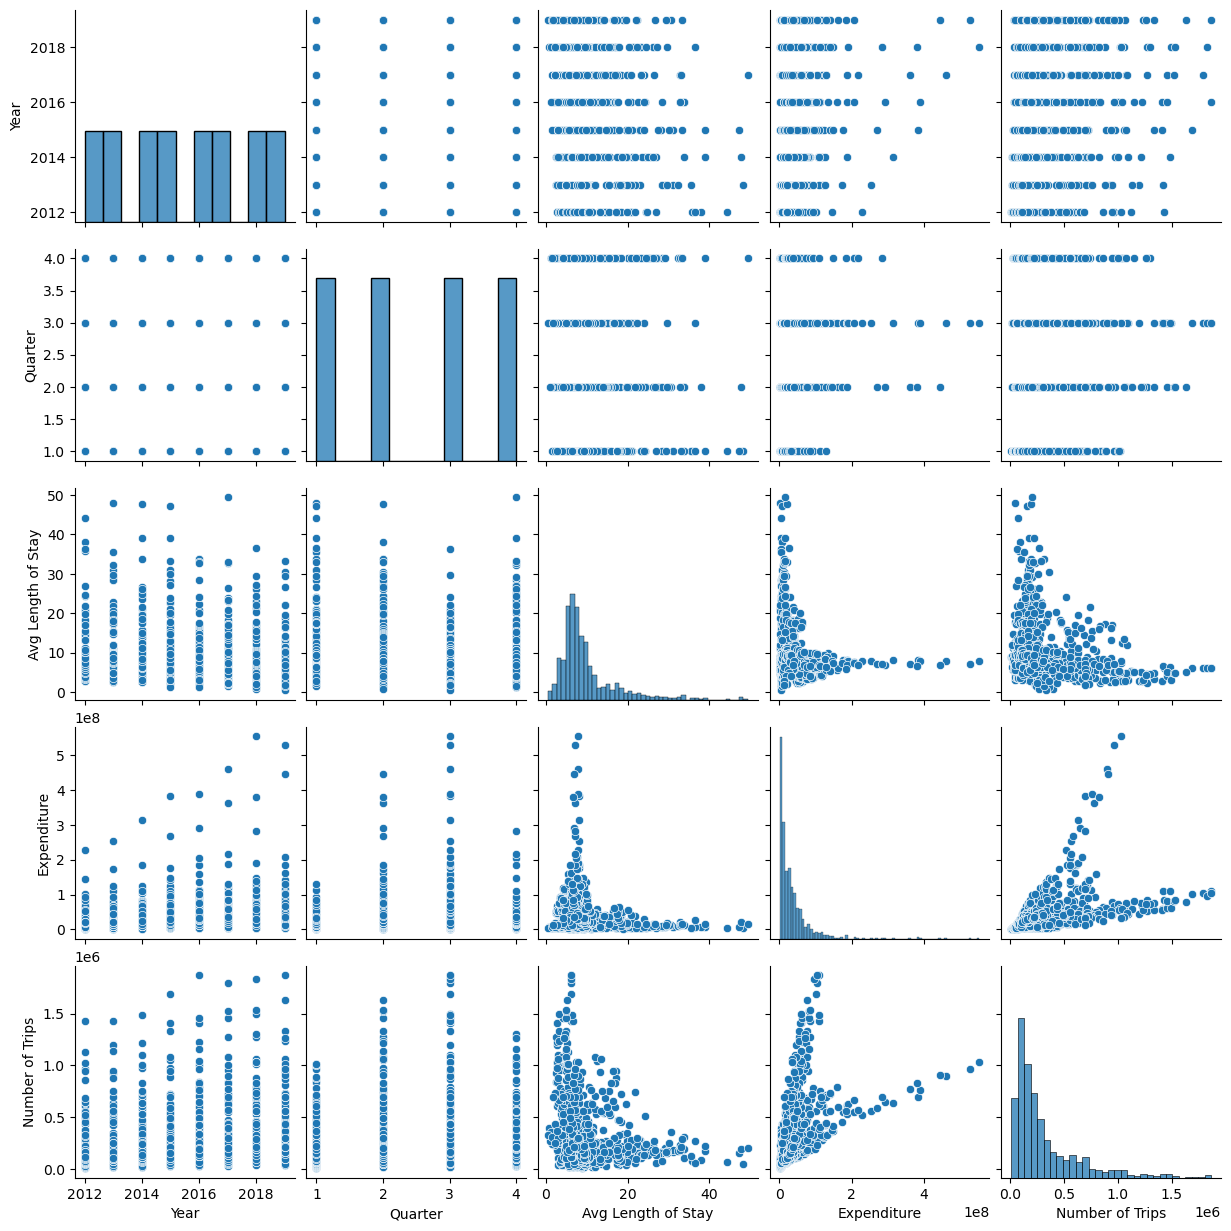

In [37]:
sns.pairplot(data_drop)

<Axes: >

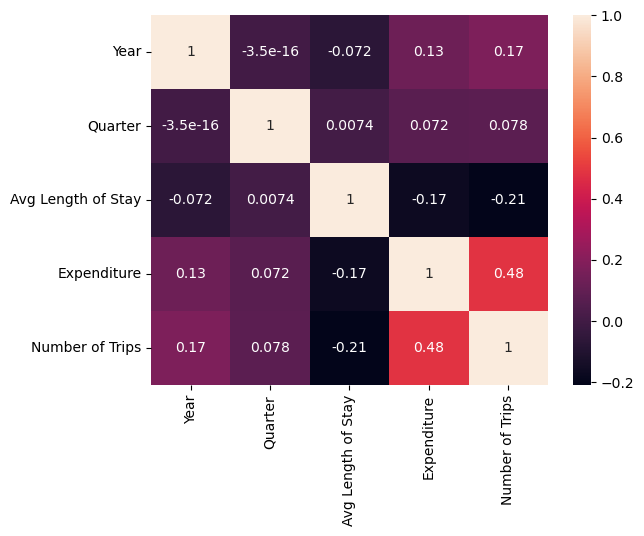

In [38]:
sns.heatmap(data_drop.drop(columns=data_drop.select_dtypes(include=['object']).columns).corr(), annot=True)

### Insights from Pairplot and Heatmap Correlation

Based on the analysis using **Pairplot** and **Heatmap Correlation**, the following key insights were derived about the dataset:

---

1. **Skewness in Data**:
   - The columns **Average Length of Stay**, **Expenditure**, and **Number of Trips** exhibit **right-skewed distributions**.
   - This indicates that most data points are concentrated on the left side of the distribution, with a tail extending to the right.

2. **High Variance**:
   - The numerical columns show **relatively high variance**, meaning the data is **dispersed and scattered**.
   - This suggests significant variability in the values, which may require normalization or scaling for further analysis.

3. **Correlation Between Columns**:
   - There is **low to medium correlation** between the columns.
   - No strong linear relationships were observed, indicating that the variables are mostly independent of each other.


### Visualizing the data

To better understand the distribution and spread of the numerical variables in the dataset, I use **histograms** and **boxplots**. These visualizations help identify patterns, skewness, outliers, and the overall spread of the data.

#### Why I Use Histograms and Boxplots
1. **Histograms**:
   - Show the distribution of a single numerical variable.
   - Help identify skewness, central tendency, and spread.
2. **Boxplots**:
   - Visualize the spread and outliers in the data.
   - Provide insights into the median, quartiles, and variability.

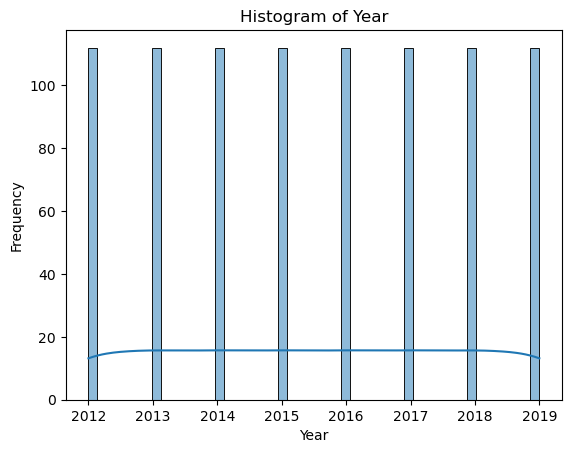

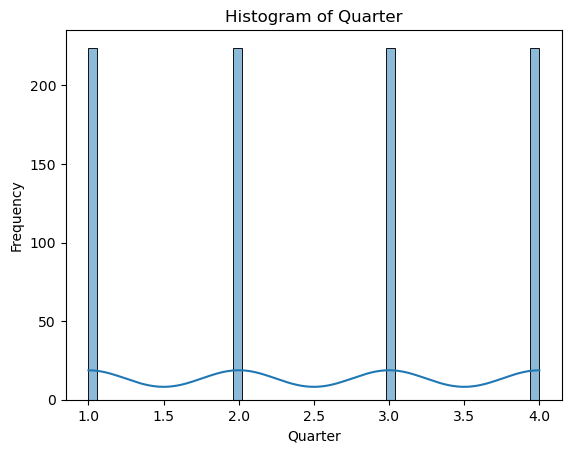

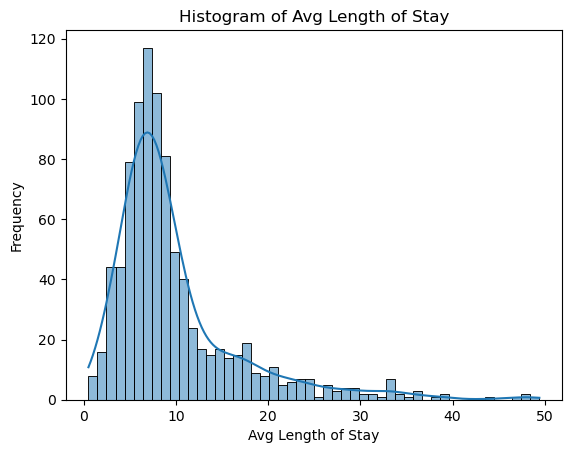

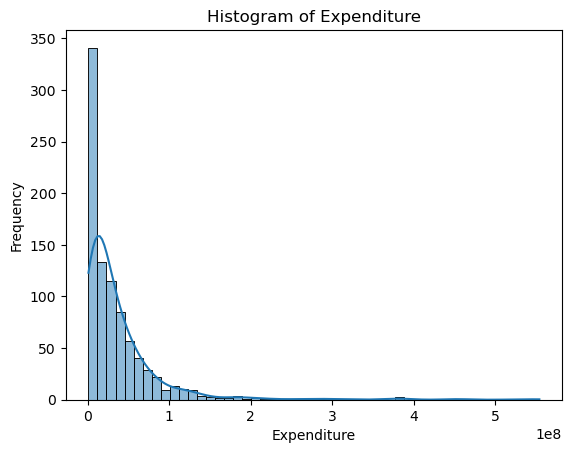

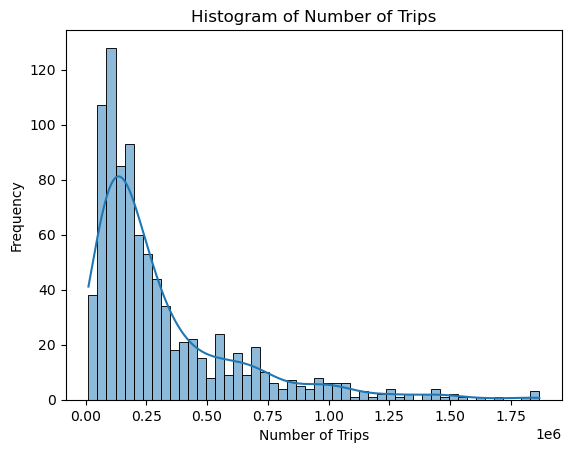

In [42]:
show_histplot(data_drop)

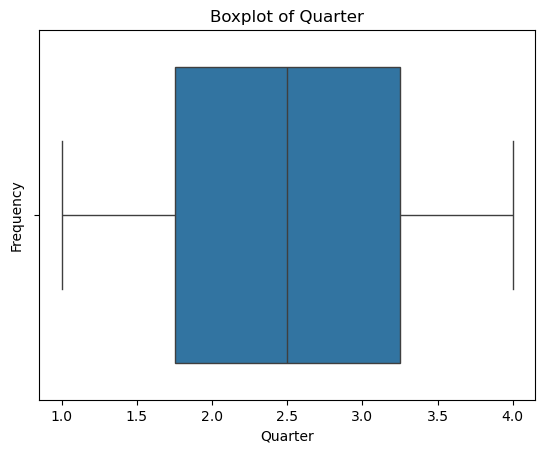

In [43]:
show_boxplot(data_drop)

## Handling Outliers in the dataset

Since the dataset is **right-skewed** and contains outliers, I used the **Interquartile Range (IQR)** method to identify and count outliers. The IQR method is robust for skewed data and provides a clear threshold for outlier detection than Z-Score method. IQR method is less sensitive to extreme values compared to the Z-score method and works well with non-normally distributed data.

In [46]:
count_outliers_iqr(data_drop)

{'Year': 0,
 'Quarter': 0,
 'Avg Length of Stay': 87,
 'Expenditure': 65,
 'Number of Trips': 66}

The dataset contains **50+ outliers**, as identified using the IQR method. Outliers cannot be removed without careful consideration, as they may carry important information or represent valid data points.  Outliers may represent rare but valid observations (for example, high spenders, long stays, etc). The significance of outliers often depends on the context of the data. Therefore, evaluating the appropriate strategies to handle these outliers is crucial.

### Scatterplot: Average Length of Stay vs Expenditure

To visualize the relationship between **Average Length of Stay** and **Expenditure**, I created a scatterplot using `Area of Residence` as the hue allows for grouping and comparison across different area of residence.

In [49]:
show_scatterplot(data=data_drop, x='Avg Length of Stay', y= 'Expenditure', hue='Area of Residence', hover=['Year','Quarter','Reason for Journey'], x_threshold=0.90)

Threshold Value: 18.65
Number of Outliers: 90


#### Decision on Avg Length of Stay Outliers

In the scatterplot of **Average Length of Stay vs Expenditure**, there are data points where the `Average Length of Stay` exceeds **~18 days** (approximately the 90th percentile), but the corresponding `Expenditure` is near **0**.
   - Longer stays (above ~18 days) with near-zero expenditure comparatively do not contribute to the economy via tourism, which is a key focus of the analysis.
   - In real-world scenarios, extended stays are expected to generate some level of economic activity (e.g., accommodation, dining, transportation).
   - Removing them ensures the analysis focuses on meaningful data that aligns with the economic objectives of tourism.

After removing **90 outliers** above the **90th percentile** (threshold of ~18 days) in the `Average Length of Stay` column, I will now:
1. **Recreate the Scatterplot** to visualize the relationship between `Average Length of Stay` and `Expenditure` without outliers.
2. **Plot Histogram** to show the distribution, skewness, central tendency, and spread of the `Average Length of Stay` column without outliers.

In [53]:
outlrs_drop_data = remove_outliers_percentile(data_drop, column='Avg Length of Stay',threshold=0.90)

Threshold Value: 18.65
Number of Outliers Removed: 90


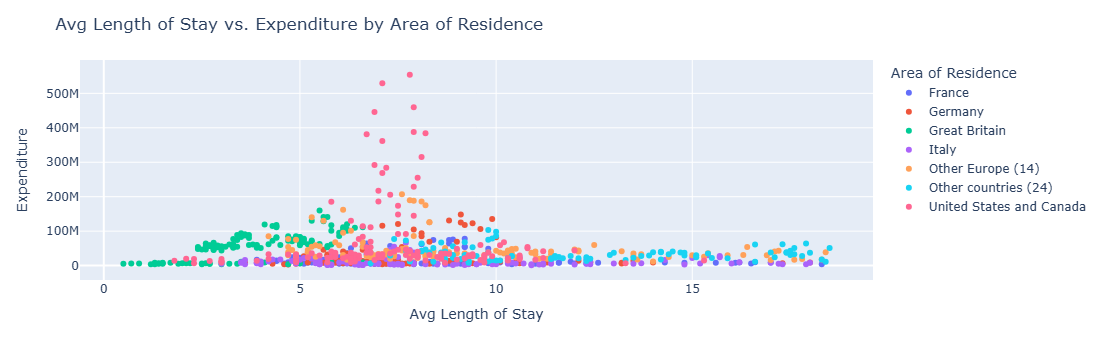

In [54]:
show_scatterplot(data=outlrs_drop_data, x='Avg Length of Stay', y='Expenditure', hue='Area of Residence')

### Scatterplot: Number of Trips vs Expenditure

This visualization shows the relationship between tourist expenditure and trip frequency

Threshold Value: 118250000.0
Number of Outliers: 45


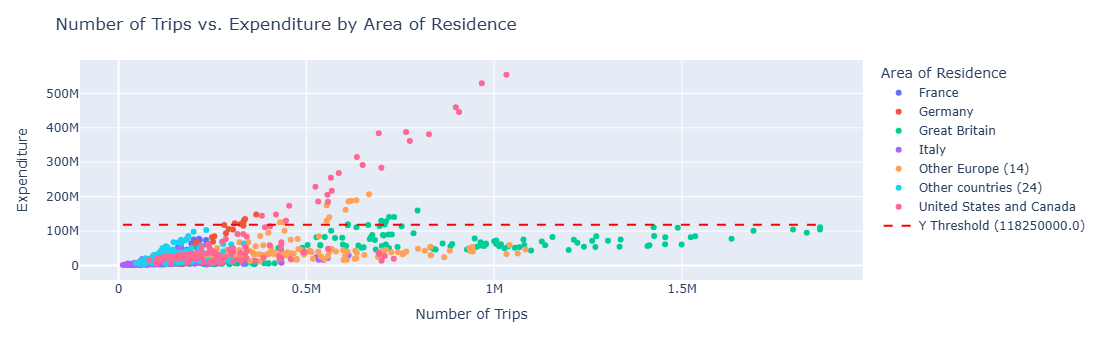

In [56]:
show_scatterplot(data=data_drop, x='Number of Trips', y='Expenditure', hue='Area of Residence', hover=['Reason for Journey'], y_threshold=0.95)

### Barplot: Year vs Expenditure

This visualization examines tourism expenditure trends over time

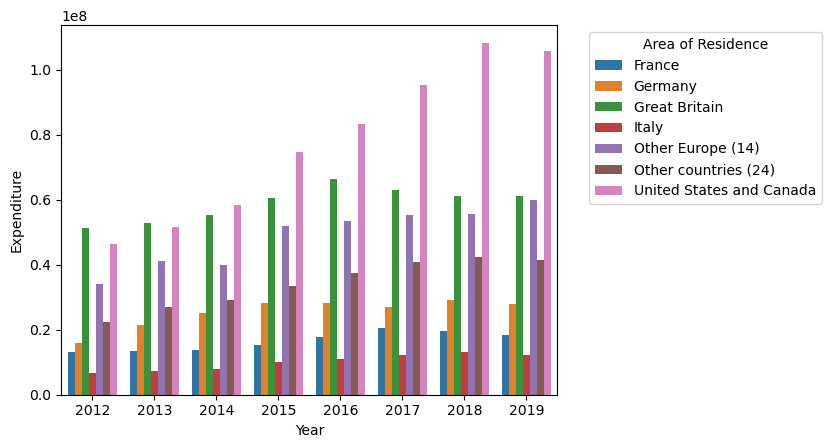

In [58]:
sns.barplot(data= outlrs_drop_data, x='Year', y = 'Expenditure', hue='Area of Residence', errorbar=None)
plt.legend(title='Area of Residence', bbox_to_anchor=(1.05, 1), loc='upper left')

#### Decision on Expenditure Outliers

From the above plots, it is clear that primary outliers originate from **United States and Canada** tourists who demonstrate significantly **higher spending patterns** over the years. These represent genuine **high-value tourists** critical for revenue analysis.

- More than 75% of top 5% expenditure records originate from United States and Canada tourists.
- While representing comparatively lesser tourist volume, United States and Canada visitors contribute more to the total tourism revenue.

Removing these values would underestimate the potential overall tourism revenue and mask potential important luxury travel segments.

Therefore, after careful analysis, I have decided to **retain the outliers** in `Expenditure` column.

#### Scatterplot: Number of Trips vs Avg Length of Stay

This scatterplot shows the relationship between Total `number of trips` by the `Area of Residence` with respect to `Avg Length of Stay`

In [62]:
show_scatterplot(data=outlrs_drop_data, x='Number of Trips', y= 'Avg Length of Stay', hue='Area of Residence', hover=['Year','Quarter','Reason for Journey'], x_threshold=0.95)

Threshold Value: 1025030.0
Number of Outliers: 41


#### Barplot: Reason for Journey vs Number of Trips

This graph shows the total `Number of Trips` made by each countries with respect to the purpose of the trip.

Threshold Value: 1025030.0
Number of Outliers: 41


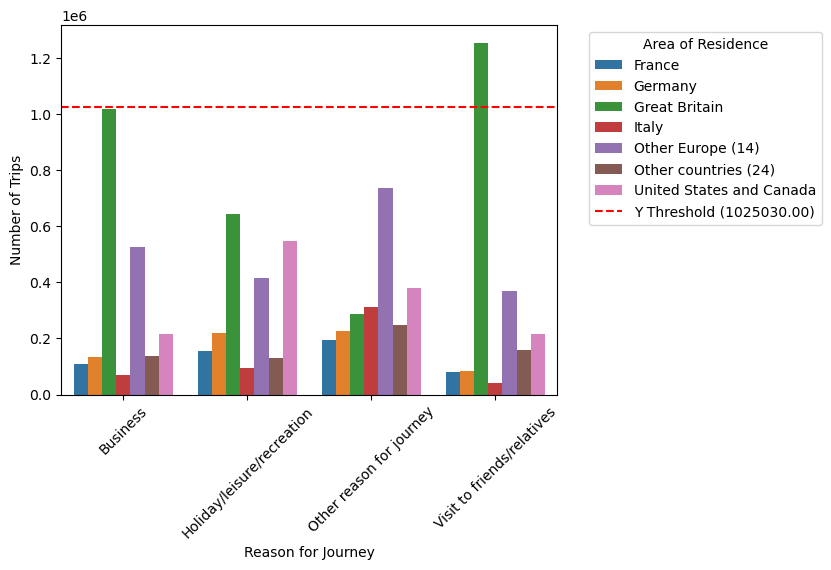

In [65]:
show_barplot(data=outlrs_drop_data, x='Reason for Journey', y='Number of Trips', hue='Area of Residence', errorbar=None, y_threshold=0.95)

#### Decision on Number of Trips outliers

The visualizations clearly reveals a cluster of data points for `Number of Trips` that are above the **95th percentile threshold**, represented by the red dashed line are isolated and deviated from the main distribution of data, which lies below this threshold.

However, it was observed that most of the data points above the threshold are associated with trips where the primary purpose was **Visit to Friends/Relatives** by **Great Britain**. This category often involves longer stays and potentially more frequent trips than typical tourist visits.

Therefore, instead of completely removing these data points, which would eliminate valuable information about this specific travel pattern, I am **capping** them at the 95th percentile by **Winsorization** method.

This approach allows us to retain the magnitude of these trips, acknowledging their higher frequency, while minimizing their influence on the overall analysis.

In [68]:
processed_data = outlrs_drop_data.copy()

In [69]:
processed_data['Number of Trips'] = winsorize(processed_data['Number of Trips'], limits=[0, 0.05])

Threshold Value: 1025030.0
Number of Outliers: 41


C:\Users\dpkk5\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning:




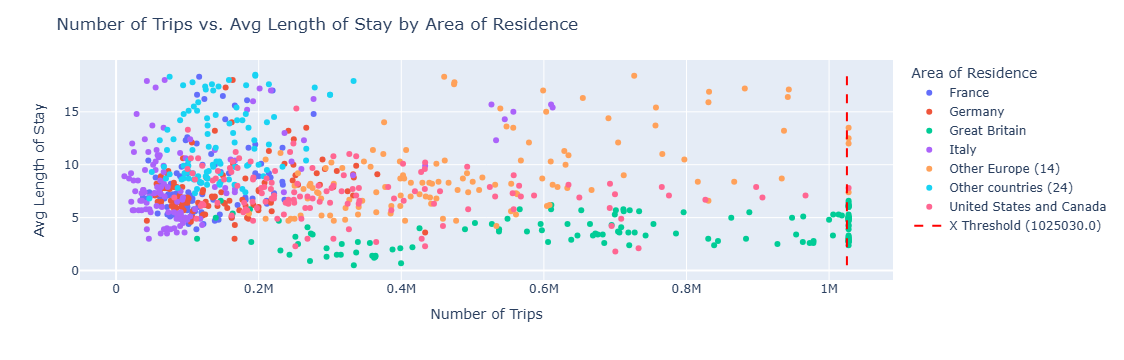

In [70]:
show_scatterplot(data=processed_data, x='Number of Trips', y= 'Avg Length of Stay', hue='Area of Residence', hover=['Year','Quarter','Reason for Journey'], x_threshold=0.95)

### Log Transformation of Strongly Right-Skewed Numerical Variable

To address the strong right-skewness in the numerical columns `Expenditure`, `Number of Trips`, I will apply **log transformation**. This transformation helps normalize the data distribution, making it more suitable for statistical modeling and visualization.

In [73]:
transformed_data = transform_data(processed_data, ['Expenditure', 'Number of Trips'], how= 'log')

#### Square root Transformation of Mildly Right-Skewed Numerical Variable

To address the mild right-skewness in the numerical columns `Avg Length of Stay`, I will apply **square root transformation**. This transformation helps normalize the data distribution, making it more suitable for statistical modeling and visualization.

In [76]:
transformed_data = transform_data(transformed_data, ['Avg Length of Stay'], how= 'square root')

In [77]:
transformed_data.head()

Year  Quarter Area of Residence Reason for Journey  Avg Length of Stay  \
0  2012        1            France           Business                 6.6   
1  2012        2            France           Business                 5.8   
2  2012        3            France           Business                 9.3   
3  2012        4            France           Business                 9.1   
4  2013        1            France           Business                 6.0   

   Expenditure  Number of Trips  Season  Expenditure_Transform  \
0    9000000.0         104859.0  Winter              16.012735   
1    6000000.0         109038.0  Spring              15.607270   
2    6000000.0         146769.0  Summer              15.607270   
3    5000000.0          71900.0  Autumn              15.424949   
4    7000000.0         100136.0  Winter              15.761421   

   Number of Trips_Transform  Avg Length of Stay_Transform  
0                  11.560381                      2.569047  
1                  11.599461                      2.408319  
2                  11.896622                      3.049590  
3                  11.183045                      3.016621  
4                  11.514295                      2.449490

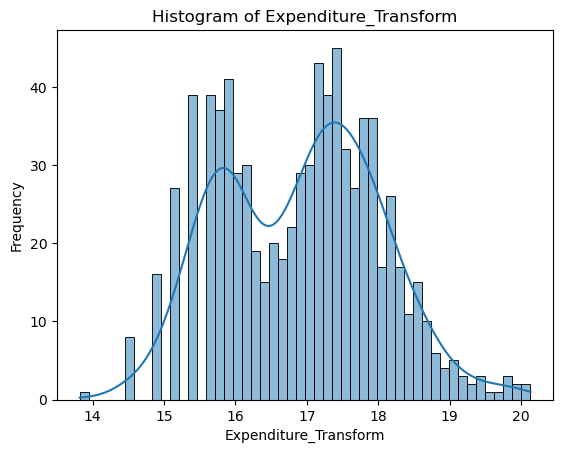

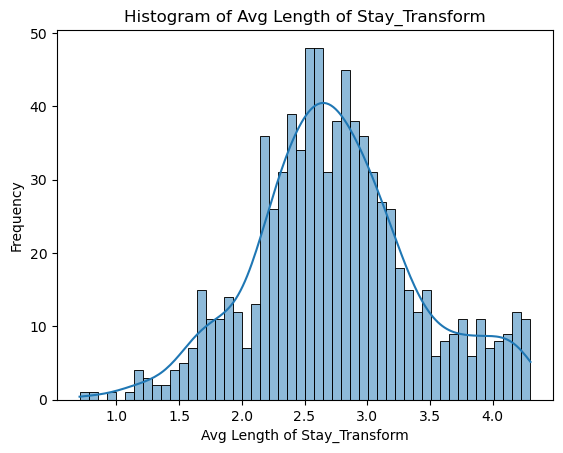

In [78]:
show_histplot(transformed_data, columns=['Expenditure_Transform', 'Number of Trips_Transform', 'Avg Length of Stay_Transform'])